In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

# avarage per age or session
m_df = male_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)


## heatmaps

In [6]:
format_plots()

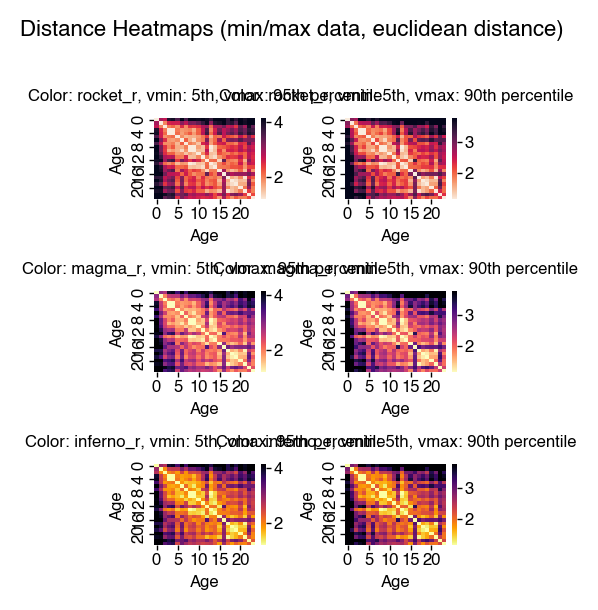

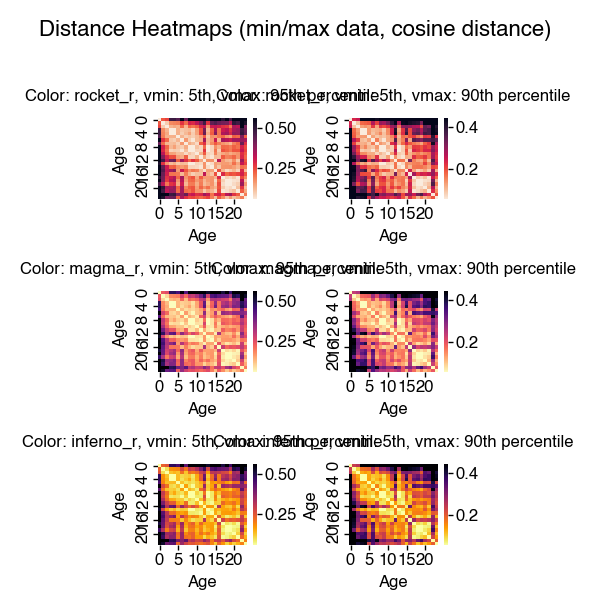

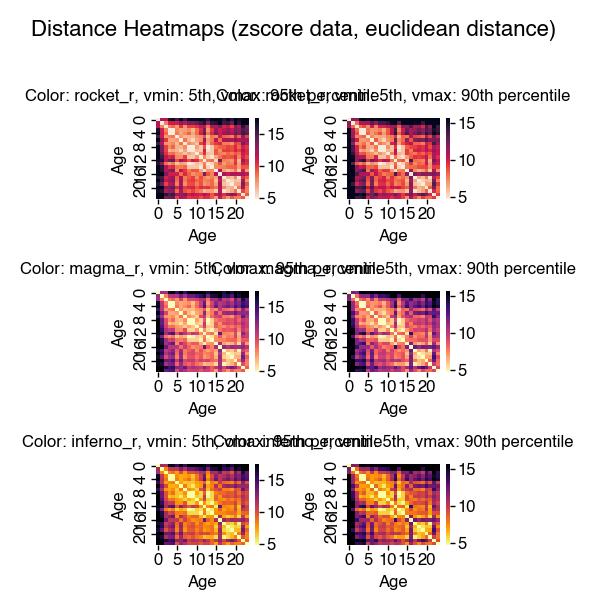

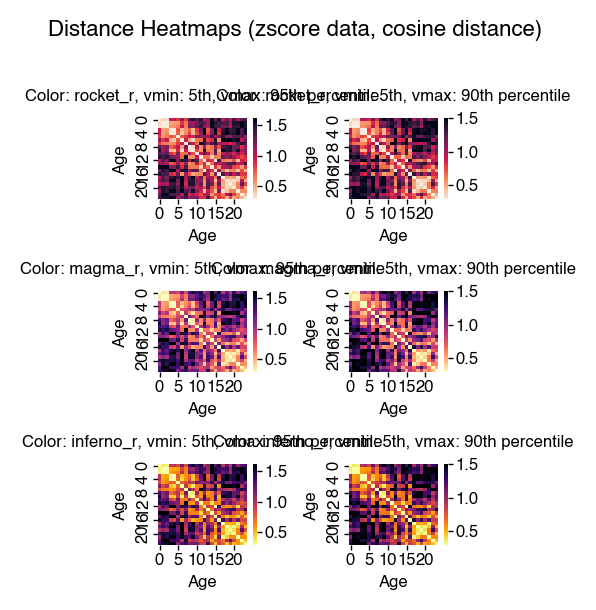

In [22]:
#dataframes = [avg_m_df, avg_m_log, avg_m_norm, avg_z_m, avg_z_log]
#data_types = ['raw', 'log', 'min/max', 'zscore', 'log_zscore']
#distance_metrics = ['euclidean', 'cosine']
#color_maps = ['cubehelix', 'mako', 'viridis', 'rocket','magma']
#percentiles_up = [99, 95, 90]
#percentiles_down = [1, 5, 10]


dataframes = [avg_m_norm,avg_z_m]
data_types = ['min/max','zscore']
distance_metrics = ['euclidean', 'cosine']
color_maps = ['rocket_r', 'magma_r','inferno_r']
percentiles_up = [95,90]
percentiles_down = [5]


for df, data_type in zip(dataframes, data_types):
    X = df.values

    for metric in distance_metrics:
        dist_matrix = squareform(pdist(X, metric=metric))

        fig, axes = plt.subplots(len(color_maps), len(percentiles_up) * len(percentiles_down), figsize=(2, 3))
        fig.suptitle(f'Distance Heatmaps ({data_type} data, {metric} distance)', fontsize=8)

        for i, cmap in enumerate(color_maps):
            for j, (vmin_perc, vmax_perc) in enumerate([(d, u) for d in percentiles_down for u in percentiles_up]):
                vmax_value = np.percentile(dist_matrix, vmax_perc)
                vmin_value = np.percentile(dist_matrix, vmin_perc)
                ax = axes[i, j]
                sns.heatmap(dist_matrix, ax=ax, cmap=cmap, vmin=vmin_value, vmax=vmax_value)
                ax.set_title(f'Color: {cmap}, vmin: {vmin_perc}th, vmax: {vmax_perc}th percentile', fontsize=6)
                ax.set_xlabel('Age')
                ax.set_ylabel('Age')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()